In [1]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from copy import deepcopy
from skimage.morphology import (erosion, dilation, closing, opening, area_closing, area_opening)
from skimage.draw import disk
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose, AveragePooling2D, LeakyReLU
from keras.models import Model
from keras.optimizers import SGD, Adam
import cv2 as cv
from keras import backend as K
from skimage.metrics import structural_similarity as ssim

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [2]:
def Normalize(train_x, train_y):
    for idx in range(len(train_x)):
        train_x[idx] = (train_x[idx] / 127.5) - 1
        train_y[idx] = (train_y[idx] / 127.5) - 1

    return train_x, train_y

In [3]:
def Crop(train_x):
    train_xx = []
    for idx in range(len(train_x)): train_xx.append(train_x[idx][0:128, :])
    
    return np.array(train_xx)

In [4]:
def Data():
    train_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator()

    train_data = train_datagen.flow_from_directory(
            r'C:\Users\mhfar\Desktop\MetalDAM\MetalDAM\images',
            color_mode="rgb",
            target_size=(137, 128),
            batch_size=32,
            class_mode='categorical',
            shuffle=False)

    segmentation_datagen = ImageDataGenerator()

    train_segmentation_data = segmentation_datagen.flow_from_directory(
            r'C:\Users\mhfar\Desktop\MetalDAM\MetalDAM\coloured_labels',
            color_mode="rgb",
            target_size=(128, 128),
            batch_size=32,
            class_mode='categorical',
            shuffle=False)

    test_data = test_datagen.flow_from_directory(
            r'C:\Users\mhfar\Desktop\MetalDAM\unlabeled',
            color_mode="rgb",
            target_size=(137, 128),
            batch_size=32,
            class_mode='categorical',
            shuffle=False)  

    train_x = np.squeeze(np.concatenate([train_data.next()[0] for i in range(train_data.__len__())]))
    train_y = np.squeeze(np.concatenate([train_segmentation_data.next()[0] for i in range(train_segmentation_data.__len__())]))
    test_x = np.squeeze(np.concatenate([test_data.next()[0] for i in range(test_data.__len__())]))

    return (Crop(train_x), train_y, Crop(test_x))

In [5]:
def UNET():
    inputs = Input((128, 128, 3))
    conv1 = Conv2D(64, 3, activation = LeakyReLU(), padding = 'same')(inputs)
    conv1 = Conv2D(64, 3, activation = LeakyReLU(), padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = LeakyReLU(), padding = 'same')(pool1)
    conv2 = Conv2D(128, 3, activation = LeakyReLU(), padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = LeakyReLU(), padding = 'same')(pool2)
    conv3 = Conv2D(256, 3, activation = LeakyReLU(), padding = 'same')(conv3)
    conv3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = LeakyReLU(), padding = 'same')(pool3)
    conv4 = Conv2D(512, 3, activation = LeakyReLU(), padding = 'same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    up5 = Conv2DTranspose(256, 2, activation = LeakyReLU(), padding = 'same')(UpSampling2D(size = (2,2))(drop4))
    merge5 = concatenate([drop3,up5], axis = 3)
    conv5 = Conv2DTranspose(256, 3, activation = LeakyReLU(), padding = 'same')(merge5)
    conv5 = Conv2DTranspose(256, 3, activation = LeakyReLU(), padding = 'same')(conv5)

    up6 = Conv2DTranspose(128, 2, activation = LeakyReLU(), padding = 'same')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2,up6], axis = 3)
    conv6 = Conv2DTranspose(128, 3, activation = LeakyReLU(), padding = 'same')(merge6)
    conv6 = Conv2DTranspose(128, 3, activation = LeakyReLU(), padding = 'same')(conv6)

    up7 = Conv2DTranspose(64, 2, activation = LeakyReLU(), padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1,up7], axis = 3)
    conv7 = Conv2DTranspose(64, 3, activation = LeakyReLU(), padding = 'same')(merge7)
    conv7 = Conv2DTranspose(64, 3, activation = LeakyReLU(), padding = 'same')(conv7)

    conv7 = Conv2DTranspose(3, 3, activation = 'tanh', padding = 'same')(conv7)
    #conv8 = Conv2D(1, 1, activation = 'tanh')(conv7)

    model = Model(inputs = inputs, outputs = conv7)
    return model

In [6]:
def CNN():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(BatchNormalization())
    model.add(Activation(LeakyReLU()))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(LeakyReLU()))
    model.add(Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [7]:
def MakeBatches(train_x, train_y):

    BATCH_SIZE  = 2
    train_dataset = tf.data.Dataset.from_tensor_slices(train_x).batch(BATCH_SIZE)
    train_dataset_seg = tf.data.Dataset.from_tensor_slices(train_y).batch(BATCH_SIZE)

    i = []
    for element in train_dataset.as_numpy_iterator(): 
        i.append(element)

    j = []
    for element in train_dataset_seg.as_numpy_iterator(): 
        j.append(element)
        
    return np.array(i), np.array(j)

In [8]:
def discriminator_loss(real_output, fake_output):

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [9]:
def generator_loss(fake_output, gen_output, target):
    Lambda = 100
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    gan_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(tf.squeeze(target) - tf.squeeze(gen_output)))
    total_gen_loss = gan_loss + Lambda * l1_loss
    return tf.squeeze(total_gen_loss)

In [10]:
train_x, train_y, test_x = Data()
#train_x, train_y = Normalize(train_x, train_y)
train_x, train_y = MakeBatches(train_x, train_y)

Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.
Found 164 images belonging to 1 classes.


In [11]:
generator = UNET()
discriminator = CNN()
generator_optimizer = Adam(learning_rate = 1e-4, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate = 1e-4, beta_1=0.5)

In [12]:
checkpoint_dir = r'C:\Users\mhfar\Desktop\MetalDAM\Models'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [13]:
@tf.function
def train_step(train_x, train_y):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(train_x, training=True)
        real_output = discriminator(train_y, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output, generated_images, train_y)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [14]:
def train(EPOCHS):
    for epoch in range(EPOCHS):
        for i in range(len(train_x)):
            xbatch = train_x[i]
            ybatch = train_y[i]
            train_step(xbatch, ybatch)
        print(epoch)
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        gen = generator
    
    checkpoint.save(file_prefix = checkpoint_prefix)

In [15]:
#train(100)

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
np.shape(train_x.reshape(-1, 128, 128, 3))

(42, 128, 128, 3)

In [22]:
func = K.function([generator.layers[0].input],[generator.layers[32].output])
u = np.squeeze(func(test_x))
np.shape(u)

(164, 128, 128, 3)

(164, 128, 128, 3)


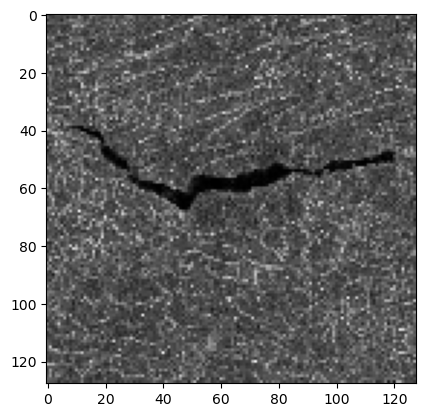

In [19]:
print(np.shape(test_x))
plt.imshow(test_x[75, :, :, :].astype(np.uint8))

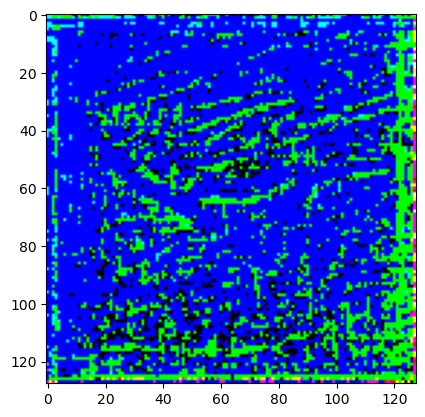

In [23]:
plt.imshow(u[75].astype(np.uint8))




